## Object Detection and Segmentation with OpenCV and Tensorflow mask RCNN

Here we show how to detect and also segment images based on Tensorflow based models. Detection is identifying a bounding box, instance segmentation requires identifying the pixels can belong to the object.

We use R-Mask CNN model with inception 2. The R-CNN is does detection in multiple stage with multiple CNN passes. At first it generated proposal regions  by studying pixel gradients and edges. Classification is run on each proposal. The final results and bounding boxes are then obtained post-processing of the individual results.

In [18]:
import numpy as np
import cv2 as cv2
print("cv2 version:",cv2.__version__)
# import os

# %matplotlib inline
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

#Routine to fix 
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

cv2 version: 4.11.0


In [19]:
np.random.randint(0, 255, size=((10), 3))

array([[ 59,  13, 241],
       [249,   8,  89],
       [ 52, 129,  83],
       [ 91, 110, 187],
       [198, 171, 252],
       [  7, 174,  34],
       [205,  80, 163],
       [ 49, 103, 131],
       [  1, 253, 133],
       [ 53, 105,   3]])

## Getting the class names

In this section we will read the coco labels file. This file contains the labels of the object the model was trained against. We will also create a COLORS array which will give a different color for each label. Note coco has 90 labels by default.

In [20]:
label_file="object_detection_classes_coco.txt"
LABELS = open(label_file).read().strip().split("\n")
np.random.seed(42) #Set seed so that we get the same results everytime
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [21]:
COLORS.shape==(90, 3)

True

In [22]:
threshold=0.9

Lets take a look at 5 of the `LABELS`.

In [23]:
LABELS[:5]

['person', 'bicycle', 'car', 'motorcycle', 'airplane']

The DNN module from CV2 supports reading of tensorflow trained object detection models. We need to load the weight and config for this. For more on this topic refer to 
https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

## Getting the Weights and Configs of the Network

In [24]:
weights="mask_rcnn_frozen_inference_graph.pb"
config="mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

In [25]:
print(weights=="mask_rcnn_frozen_inference_graph.pb")
config=="mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

True


True

In [26]:
!head -10 mask_rcnn_frozen_inference_graph.pb

'head' is not recognized as an internal or external command,
operable program or batch file.


**Note:**

- `cv2.dnn.readNetFromTensorflow(weights, config)` : Reads a network model stored in TensorFlow framework's format.
 
  - `weights`	: path to the `.pb` file with binary protobuf description of the network architecture
 - `config` : path to the `.pbtxt` file that contains text graph definition in protobuf format. Resulting Net object is built by text graph using weights from a binary one that let us make it more flexible.

In [27]:
net = cv2.dnn.readNetFromTensorflow(weights, config)

In [28]:
str(type(net))=="<class 'cv2.dnn_Net'>"

False

Reading the image file and converting it to a blob for processing.

In [39]:
img = cv2.imread('dining_table.jpg')

**Note:**

- In the context of deep learning, a ***blob*** is also the entire image pre-processed and prepared for classification/training. Such pre-processing usually entails mean subtraction and scaling.

- `cv2.dnn.blobFromImage` : a deep learning method from OpenCV that creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels. 
 - `image` : input image (with 1-, 3- or 4-channels).
 - `swapRB` :	flag which indicates that swap first and last channels in 3-channel image is necessary.
 - `crop` :	flag which indicates whether image will be cropped after resize or not

In [40]:
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

**Note:**

- `net.setInput(blob)` : Sets the new input value for the network.
 - 	`blob`: A new blob.


In [41]:
net.setInput(blob)

In [42]:
str(type(img))=="<class 'numpy.ndarray'>"

True

This model returns both masks and boxes. 

**Note:**
- `net.forward` : Perform a forward pass of the Mask R-CNN. It returns

 (1) the bounding box  coordinates
of the objects in the image along with classID, confidence scores

 (2) the pixel-wise segmentation
for each specific object

from the output layers named as ‘detection_out_final‘ and ‘detection_masks‘ in the network.

In [43]:
(boxes, masks) = net.forward(["detection_out_final",
		"detection_masks"])
# print ("Shape of boxes", boxes.shape)
# print ("Shape of masks", masks.shape)

In [44]:
type(masks)

numpy.ndarray

The boxes have classID, confidence scores and 4 points identifying the bounding box. This bounding box is normalised and has to be multipied by the actual size of the image to get actual values.

The masks have 

- 100 detections 
- Each detection has 90 classes
- There coordinates of a 15 pointed polygon, each containing a confidence value.


If the box probability exceeds the threshold, we also process the mask polygons
- Map it to the bounding box and identify all pixels that the mask covers
- If the pixel confidence exceeds threshold create a mask 
- ROI is Region of Interest in the actual picture. Lets color of all pixels in the ROI
- The color of ROI is made into blend of its actual colors and color allocated to classID
Finally everything is printed

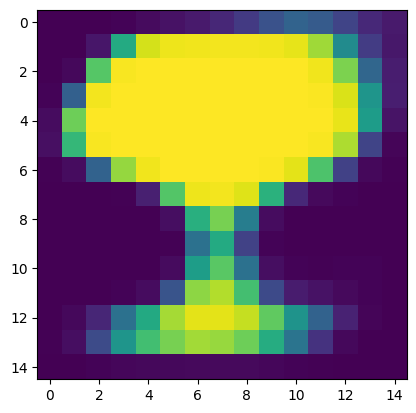

Shape of individual mask (15, 15)
Mask after resize (339, 143)
Mask after threshold (339, 143)
ROI Shape (12777, 3)
wine glass [156, 21, 112]


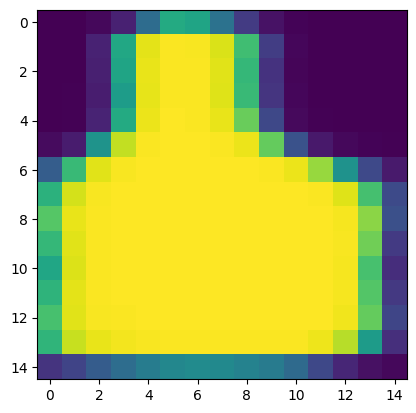

Shape of individual mask (15, 15)
Mask after resize (343, 82)
Mask after threshold (343, 82)
ROI Shape (13302, 3)
bottle [209, 226, 77]


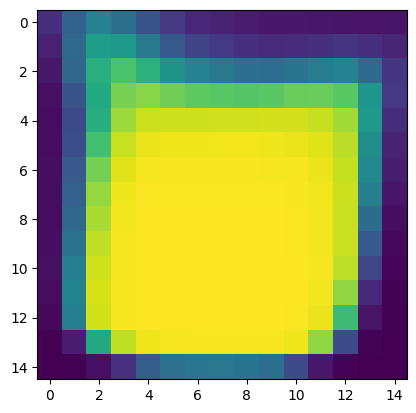

Shape of individual mask (15, 15)
Mask after resize (168, 90)
Mask after threshold (168, 90)
ROI Shape (6018, 3)
vase [166, 56, 167]


In [45]:
for i in range(0, boxes.shape[2]): #For each detection
    classID = int(boxes[0, 0, i, 1]) #Class ID
    confidence = boxes[0, 0, i, 2] #Confidence scores
    if confidence > threshold:
        (H, W) = img.shape[:2]
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H]) #Bounding box
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object,       
        mask = masks[i, classID]
        plt.imshow(mask)
        plt.show()
        print ("Shape of individual mask", mask.shape)
        
        # resize the mask such that it's the same dimensions of
        # the bounding box, and interpolation gives individual pixel positions
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_CUBIC)
        print ("Mask after resize", mask.shape)
        # then finally threshold to create a *binary* mask
        mask = (mask > threshold)
        print ("Mask after threshold", mask.shape)
        
        # extract the ROI of the image but *only* extracted the
        # masked region of the ROI
        roi = img[startY:endY, startX:endX][mask]
        print ("ROI Shape", roi.shape)
        # grab the color used to visualize this particular class,
        # then create a transparent overlay by blending the color
        # with the ROI
        color = COLORS[classID]
        blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

        # Change the colors in the original to blended color
        img[startY:endY, startX:endX][mask] = blended

        color = COLORS[classID]
        color = [int(c) for c in color]
        print (LABELS[classID], color)
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

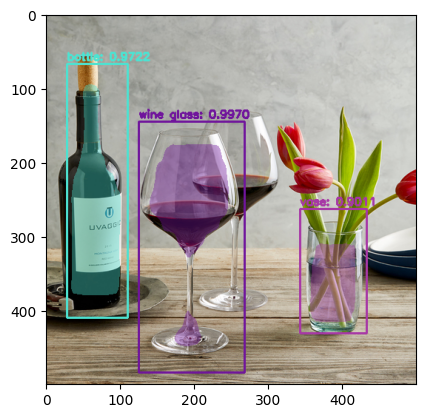

In [46]:
plt.imshow(fixColor(img))

In [37]:
roi.shape==(13497, 3)

False

In [38]:
color==[209, 226, 77]

False